In [56]:
!pip install category_encoders

In [57]:
!pip install seaborn

In [58]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification,make_moons
from category_encoders import BackwardDifferenceEncoder
from matplotlib.colors import ListedColormap
from keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report,confusion_matrix

GETTING THE DATASET AND PREPARING IT

In [59]:
data=pd.read_csv('/content/Housing Pricing.csv')

In [60]:
data.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500


In [61]:
data.shape

(1460, 77)

In [62]:
data.drop('Id',inplace=True,axis=1)

In [63]:
data.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500


In [64]:
original_features=list(data.columns)
len(original_features)

76

In [65]:
features_missing_values=list(data.columns[data.isna().any()])
len(features_missing_values)

15

In [66]:
len(data)

1460

FILL IN THE MISSING VALUES

In [67]:
bfill,mean_fill=[],[]

In [68]:
for feature in features_missing_values:
  print(feature,' ',data[feature].isna().sum()/len(data)*100,' ',data[feature].dtype)
  if data[feature].dtype=='float64':
    mean_fill.append(feature)
  else:
    bfill.append(feature)

LotFrontage   17.73972602739726   float64
MasVnrType   0.547945205479452   object
MasVnrArea   0.547945205479452   float64
BsmtQual   2.5342465753424657   object
BsmtCond   2.5342465753424657   object
BsmtExposure   2.6027397260273974   object
BsmtFinType1   2.5342465753424657   object
BsmtFinType2   2.6027397260273974   object
Electrical   0.0684931506849315   object
FireplaceQu   47.26027397260274   object
GarageType   5.5479452054794525   object
GarageYrBlt   5.5479452054794525   float64
GarageFinish   5.5479452054794525   object
GarageQual   5.5479452054794525   object
GarageCond   5.5479452054794525   object


In [69]:
mean_fill

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [70]:
for feature in mean_fill:
    data[feature].fillna(data[feature].mean(),inplace=True)

In [71]:
for feature in bfill:
    data[feature].fillna(method='bfill',inplace=True)

In [72]:
data.columns[data.isna().any()]

Index(['FireplaceQu'], dtype='object')

In [73]:
data['FireplaceQu'].isna().sum()

2

In [74]:
data['FireplaceQu'].fillna(method='ffill',inplace=True)

**ENCODE THE DATASET**



In [75]:
categorical_features=list(data.select_dtypes(include=['object']).columns)
categorical_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [76]:
numerical=list(set(original_features)-set(categorical_features))
numerical

['GarageYrBlt',
 'BsmtFinSF2',
 'GarageArea',
 'OpenPorchSF',
 'LotFrontage',
 'OverallCond',
 'PoolArea',
 '2ndFlrSF',
 'MiscVal',
 'YrSold',
 'FullBath',
 'BsmtHalfBath',
 'MasVnrArea',
 'ScreenPorch',
 'GrLivArea',
 'MoSold',
 'LowQualFinSF',
 'HalfBath',
 'TotRmsAbvGrd',
 'GarageCars',
 '1stFlrSF',
 'KitchenAbvGr',
 'YearRemodAdd',
 'LotArea',
 '3SsnPorch',
 'TotalBsmtSF',
 'EnclosedPorch',
 'YearBuilt',
 'WoodDeckSF',
 'OverallQual',
 'SalePrice',
 'BsmtFullBath',
 'Fireplaces',
 'BsmtUnfSF',
 'BedroomAbvGr',
 'MSSubClass',
 'BsmtFinSF1']

In [77]:
categorical_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [78]:
nominal=['MSZoning','LandContour','Neighborhood']
ordinal=list(set(categorical_features)-set(nominal))

In [79]:
target=['SalePrice']

In [80]:
df_nominal=pd.get_dummies(data[nominal])

In [81]:
for feature in ordinal:
  data[feature]=data[feature].astype('category').cat.codes

df_ordinal=data[ordinal]

In [82]:
data[numerical]

,GarageYrBlt,BsmtFinSF2,GarageArea,OpenPorchSF,LotFrontage,OverallCond,PoolArea,2ndFlrSF,MiscVal,YrSold,FullBath,BsmtHalfBath,MasVnrArea,ScreenPorch,GrLivArea,MoSold,LowQualFinSF,HalfBath,TotRmsAbvGrd,GarageCars,1stFlrSF,KitchenAbvGr,YearRemodAdd,LotArea,3SsnPorch,TotalBsmtSF,EnclosedPorch,YearBuilt,WoodDeckSF,OverallQual,SalePrice,BsmtFullBath,Fireplaces,BsmtUnfSF,BedroomAbvGr,MSSubClass,BsmtFinSF1
0,2003.0,0,548,61,65.0,5,0,854,0,2008,2,0,196.0,0,1710,2,0,1,8,2,856,1,2003,8450,0,856,0,2003,0,7,208500,1,0,150,3,60,706
1,1976.0,0,460,0,80.0,8,0,0,0,2007,2,1,0.0,0,1262,5,0,0,6,2,1262,1,1976,9600,0,1262,0,1976,298,6,181500,0,1,284,3,20,978
2,2001.0,0,608,42,68.0,5,0,866,0,2008,2,0,162.0,0,1786,9,0,1,6,2,920,1,2002,11250,0,920,0,2001,0,7,223500,1,1,434,3,60,486
3,1998.0,0,642,35,60.0,5,0,756,0,2006,1,0,0.0,0,1717,2,0,0,7,3,961,1,1970,9550,0,756,272,1915,0,7,140000,1,1,540,3,70,216
4,2000.0,0,836,84,84.0,5,0,1053,0,2008,2,0,350.0,0,2198,12,0,1,9,3,1145,1,2000,14260,0,1145,0,2000,192,8,250000,1,1,490,4,60,655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1999.0,0,460,40,62.0,5,0,694,0,2007,2,0,0.0,0,1647,8,0,1,7,2,953,1,2000,7917,0,953,0,1999,0,6,175000,0,1,953,3,60,0
1456,1978.0,163,500,0,85.0,6,0,0,0,2010,2,0,119.0,0,2073,2,0,0,7,2,2073,1,1988,13175,0,1542,0,1978,349,6,210000,1,2,589,3,20,790
1457,1941.0,0,252,60,66.0,9,0,1152,2500,2010,2,0,0.0,0,2340,5,0,0,9,1,1188,1,2006,9042,0,1152,0,1941,0,7,266500,0,2,877,4,70,275
1458,1950.0,1029,240,0,68.0,6,0,0,0,2010,1,0,0.0,0,1078,4,0,0,5,1,1078,1,1996,9717,0,1078,112,1950,366,5,142125,1,0,0,2,20,49


In [83]:
new_data=pd.concat([df_nominal,df_ordinal,data[numerical]],axis=1)

In [84]:
new_data.shape

(1460, 107)

**STANDARDIZE THE DATASET**

In [85]:
new_data.drop('SalePrice',axis=1,inplace=True)

In [86]:
X=new_data.to_numpy()

In [87]:
X[0]

array([0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
       4.000e+00, 1.300e+01, 1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00,
       2.000e+00, 2.000e+00, 0.000e+00, 1.200e+01, 0.000e+00, 1.000e+00,
       4.000e+00, 2.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 5.000e+00,
       3.000e+00, 2.000e+00, 8.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
       4.000e+00, 6.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
       0.000e+00, 3.000e+00, 5.000e+00, 2.000e+00, 2.003e+03, 0.000e+00,
       5.480e+02, 6.100e+01, 6.500e+01, 5.000e+00, 0.000e+00, 8.540e+02,
       0.000e+00, 2.008e+03, 2.000e+00, 0.000e+00, 

In [88]:
X=StandardScaler().fit_transform(X)

In [89]:
X[0]

array([-0.08304548, -0.21585871, -0.10526316,  0.51813339, -0.41895507,
       -0.21235968, -0.18831089, -0.15899968,  0.33712564, -0.10854037,
       -0.03703704, -0.10526316, -0.20339487, -0.1398323 ,  2.95522137,
       -0.19025216, -0.27116307, -0.23917551, -0.16124951, -0.10854037,
       -0.1863522 , -0.42683279, -0.07875671, -0.22941573, -0.16998114,
       -0.23595776, -0.28963792, -0.13199092, -0.23106504, -0.20521398,
       -0.25018188, -0.13199092, -0.16347148, -0.08712888, -0.22571613,
       -0.77797579,  0.36420746,  0.75162623, -0.71775144,  0.303692  ,
       -0.23012211, -0.12579688, -0.40779461, -0.40936914, -0.88465767,
        0.74309239, -0.41169079, -1.23804229,  0.18797343, -0.03628912,
        1.11993319, -0.29055229,  0.60466978,  0.30941909,  0.75073056,
        0.28974476,  0.31386709,  0.28780036,  0.06423821, -0.49151573,
        0.22403433,  0.25597761,  0.2085023 ,  0.26381257,  0.83559903,
       -0.12304604, -0.02618016,  0.64046232,  1.02668924, -0.03

In [90]:
y=data[target]

In [91]:
y=y.to_numpy()

In [92]:
y.shape

(1460, 1)

In [93]:
y

array([[208500],
       [181500],
       [223500],
       ...,
       [266500],
       [142125],
       [147500]])

In [94]:
y=StandardScaler().fit_transform(y)

In [95]:
y

array([[ 0.34727322],
       [ 0.00728832],
       [ 0.53615372],
       ...,
       [ 1.07761115],
       [-0.48852299],
       [-0.42084081]])

In [96]:
X.shape

(1460, 106)

**FEATURE SELETION USING L1**

In [97]:
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 37)

In [98]:
X = data.drop("SalePrice",1)
y = data["SalePrice"]
regressor=LassoCV()
regressor.fit(X,y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [100]:
new_x = PowerTransformer().fit_transform(data)

test_data = pd.DataFrame(new_x,columns=data.columns)
test_data = pd.concat([test_data[numerical],test_data[target]],axis=1)
test_data

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


,GarageYrBlt,BsmtFinSF2,GarageArea,OpenPorchSF,LotFrontage,OverallCond,PoolArea,2ndFlrSF,MiscVal,YrSold,FullBath,BsmtHalfBath,MasVnrArea,ScreenPorch,GrLivArea,MoSold,LowQualFinSF,HalfBath,TotRmsAbvGrd,GarageCars,1stFlrSF,KitchenAbvGr,YearRemodAdd,LotArea,3SsnPorch,TotalBsmtSF,EnclosedPorch,YearBuilt,WoodDeckSF,OverallQual,SalePrice,BsmtFullBath,Fireplaces,BsmtUnfSF,BedroomAbvGr,MSSubClass,BsmtFinSF1,SalePrice
0,1.118270,-0.359384,0.383899,0.841820,-0.156500,-0.477387,-0.069409,1.170239,-0.192177,0.140053,0.797246,-0.243940,1.218044,-0.293785,0.528531,-1.694229,-0.134652,1.284128,0.946380,0.273835,-0.799624,-0.172658,0.908055,-0.141171,-0.129279,-0.404029,-0.407595,1.151867,-0.950337,0.667499,0.571155,1.175573,-1.027341,-0.887576,0.170752,0.493460,0.797537,0.571155
1,-0.277361,-0.359384,-0.004602,-1.071307,0.536617,2.011352,-0.069409,-0.871454,-0.192177,-0.613715,0.797246,4.099375,-0.827466,-0.293785,-0.382755,-0.444891,-0.134652,-0.773692,-0.234627,0.273835,0.429151,-0.172658,-0.621670,0.105609,-0.129279,0.508177,-0.407595,0.006695,1.213714,-0.042192,0.227627,-0.838866,0.784005,-0.434388,0.170752,-1.164269,1.011471,0.227627
2,0.995940,-0.359384,0.641990,0.668453,-0.011160,-0.477387,-0.069409,1.172896,-0.192177,0.140053,0.797246,-0.243940,1.179948,-0.293785,0.659112,0.987490,-0.134652,1.284128,-0.234627,0.273835,-0.568533,-0.172658,0.835594,0.413721,-0.129279,-0.253787,-0.407595,1.055357,-0.950337,0.667499,0.741869,1.175573,0.784005,-0.048083,0.170752,0.493460,0.571325,0.741869
3,0.818697,-0.359384,0.786092,0.584540,-0.407405,-0.477387,-0.069409,1.146834,-0.192177,-1.368874,-1.025173,-0.243940,-0.827466,-0.293785,0.540797,-1.694229,-0.134652,-0.773692,0.389921,1.759713,-0.429428,-0.172658,-0.863478,0.095490,-0.129279,-0.644806,2.456640,-1.629540,-0.950337,0.667499,-0.425386,1.175573,0.784005,0.183337,0.170752,0.698191,0.142272,-0.425386
4,0.936036,-0.359384,1.583257,0.991895,0.708754,-0.477387,-0.069409,1.209630,-0.192177,0.140053,0.797246,-0.243940,1.324337,-0.293785,1.282894,1.963461,-0.134652,1.284128,1.448615,1.759713,0.124698,-0.172658,0.694898,0.877127,-0.129279,0.254387,-0.407595,1.007861,1.079695,1.350924,1.015293,1.175573,0.784005,0.077485,1.382874,0.493460,0.750541,1.015293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.876959,-0.359384,-0.004602,0.645943,-0.305678,-0.477387,-0.069409,1.130187,-0.192177,-0.613715,0.797246,-0.243940,-0.827466,-0.293785,0.415837,0.646025,-0.134652,1.284128,0.389921,0.273835,-0.456061,-0.172658,0.694898,-0.266808,-0.129279,-0.177387,-0.407595,0.960863,-0.950337,-0.042192,0.136679,-0.838866,0.784005,0.909505,0.170752,0.493460,-1.353159,0.136679
1456,-0.191075,2.782472,0.173581,-1.071307,0.751059,0.440551,-0.069409,-0.871454,-0.192177,1.643336,0.797246,-0.243940,1.114698,-0.293785,1.106859,-1.694229,-0.134652,-0.773692,0.389921,0.273835,1.946238,-0.172658,-0.041619,0.722071,-0.129279,1.092127,-0.407595,0.080711,1.260813,-0.042192,0.588812,1.175573,1.638448,0.282161,0.170752,-1.164269,0.869532,0.588812
1457,-1.451809,-0.359384,-0.987927,0.834100,-0.107640,2.698415,-0.069409,1.226211,5.203549,1.643336,0.797246,-0.243940,-0.827466,-0.293785,1.471180,-0.444891,-0.134652,-0.773692,1.448615,-1.047926,0.240338,-0.172658,1.134227,-0.010330,-0.129279,0.269755,-0.407595,-1.061347,-0.950337,0.667499,1.170202,-0.838866,1.638448,0.790731,1.382874,0.698191,0.261742,1.170202
1458,-1.203115,2.783731,-1.048544,-1.071307,-0.011160,0.440551,-0.069409,-0.871454,-0.192177,1.643336,-1.025173,-0.243940,-0.827466,-0.293785,-0.854788,-0.838080,-0.134652,-0.773692,-0.947362,-1.047926,-0.065163,-0.172658,0.429676,0.129088,-0.129279,0.106028,2.454153,-0.823991,1.274883,-0.783171,-0.387136,1.175573,-1.027341,-2.064084,-1.062477,-1.164269,-0.460226,-0.387136


L1 selected only  11  features out of  36  from the transformed dataset 


Text(0.5, 1.0, 'Feature Selection Using L1 Embedder')

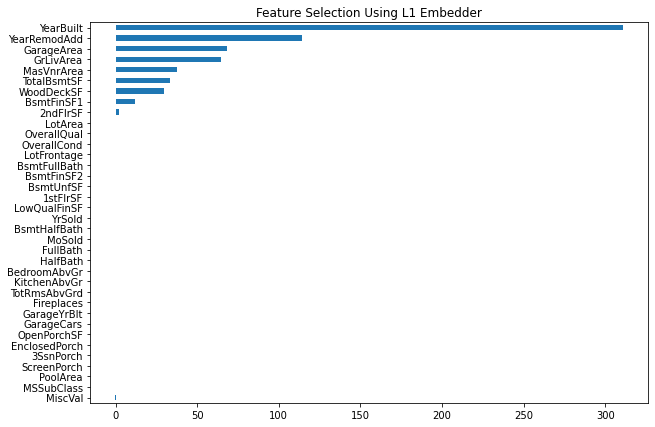

In [101]:
coef_col = pd.Series(regressor.coef_,index=X.columns)

#print(coef_col)
sorted_coef = coef_col.sort_values()
matplotlib.rcParams['figure.figsize']=(10.0,7.0)
sorted_coef.plot(kind="barh")

no_of_selected_features = sum(coef_col != 0)
no_of_rejected_features = sum(coef_col == 0)
total_features = no_of_selected_features + no_of_rejected_features
print("L1 selected only ",no_of_selected_features," features out of ",total_features," from the transformed dataset ")
plt.title("Feature Selection Using L1 Embedder")

**TRAINING AND TESTING THE MODEL**

In [102]:
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.legend()

In [103]:
def plot_decision_boundary(func, X, y,epochs, figsize=(9, 6)):

    xmin, ymin = X.min(axis=1) - 0.1
    xmax, ymax = X.max(axis=1) + 0.1
    hticks = np.linspace(xmin, xmax, epochs+1)
    vticks = np.linspace(ymin, ymax, epochs+1)
    
    xx, yy = np.meshgrid(hticks, vticks)
    xy = np.c_[xx.ravel(), yy.ravel()]
    z = func(xy)
    zz = z.reshape(xx.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(xx, yy, zz, cmap=cm, alpha=0.8)
    
    ax_z = fig.colorbar(contour)
    ax_z.set_label("$P(y = 1)$")
    ax_z.set_ticks([0, 0.2, 0.5, 0.7, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel("x_1")
    plt.ylabel("x_2")

    plot_data(X,y)

In [104]:
model=Sequential()
model.add(Dense(1, input_shape=(1,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['Precision','Recall'])

history = model.fit(X, y, verbose=0, epochs=100)

ValueError: ignored

In [ ]:
epochs=200

model_2 = Sequential()
model_2.add(Dense(4, input_shape=(2,), activation='tanh'))
model_2.add(Dense(2, activation='tanh'))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(Adam(learning_rate=0.01), 'binary_crossentropy', metrics=['Precision','Recall'])

history = model_2.fit(X, y, verbose=0, epochs=epochs)


In [ ]:
model_2.summary()

In [ ]:
historydf=pd.DataFrame(history.history, index=history.epoch)
historydf.head()

In [ ]:
historydf['F-Measure']=(2*historydf['precision']*historydf['recall'])/(historydf['precision']+historydf['recall'])

In [ ]:
historydf.head()

In [ ]:
historydf.drop(['precision','recall'],axis=1,inplace=True)

In [ ]:
final_loss=historydf['loss'].to_numpy()[-1]
final_f1=historydf['F-Measure'].to_numpy()[-1]

In [ ]:
historydf.plot()
plt.title('Final Loss: %.3f, Final F1_score: %.3f' % (final_loss, final_f1))

In [ ]:
plt.show()

In [ ]:
plot_decision_boundary(lambda X_test: model_2.predict(X_test), X_test, y_test,epochs)